# Load Data

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
choice_data_dprime_threeRounds=np.load('data_dprime_3rounds.npy')
choice_data_dprime_threeRounds=(choice_data_dprime_threeRounds-np.mean(choice_data_dprime_threeRounds))/np.std(choice_data_dprime_threeRounds)
choice_data_dprime_threeRounds_r=np.load('data_dprime_3rounds_no_equals.npy')
choice_data_dprime_threeRounds_r=(choice_data_dprime_threeRounds_r-np.mean(choice_data_dprime_threeRounds_r))/np.std(choice_data_dprime_threeRounds_r)

choice_data_dprime_threeRounds_nn=np.load('data_dprime_3rounds_no_negs.npy')
choice_data_dprime_threeRounds_nn=(choice_data_dprime_threeRounds_nn-np.mean(choice_data_dprime_threeRounds_nn))/np.std(choice_data_dprime_threeRounds_nn)


print('averages across conditions:\n baseline:    unpopular:     popular:')
print(np.mean(np.mean(choice_data_dprime_threeRounds_r,axis=0),axis=1))

choice_data_dprime=np.load('data_dprime_full.npy')
choice_data_dprime=(choice_data_dprime-np.mean(choice_data_dprime))/np.std(choice_data_dprime)
choice_data_reduced=np.load('data_dprime_reduced.npy')
likeable_binary=np.load('likable_binary.npy')
likeable_no_equals=np.load('likeable_no_equals.npy')
likeable_no_negs=np.load('likeable_no_negs.npy')
liks=[]
unliks=[]
for sub in range(len(likeable_no_equals)):
    if likeable_binary[sub]==1:
        liks.append(choice_data_dprime_threeRounds_r[sub])
    else:
        unliks.append(choice_data_dprime_threeRounds_r[sub])
liks=np.asarray(liks)
unliks=np.asarray(unliks)
print('')
print('averages across group2:\n baseline:    unpopular:     popular:')
print(np.mean(np.mean(liks,axis=0),axis=1))
print('')
print('averages across group1:\n baseline:    unpopular:     popular:')
print(np.mean(np.mean(unliks,axis=0),axis=1))
cool_and_lik_binary=np.load('pop_and_lik_grouping.npy')

# zeros=0
# for i in cool_and_lik_binary:
#     if i==0:
#         zeros+=1
# print('zeros={}'.format(zeros))

own_soc_status=np.load('grouping_variable_social_pref_zscored.npy')
order_condition=np.load('order_data.npy')
num_subjects=len(choice_data_dprime)
print('Number subjects: {}'.format(num_subjects))

averages across conditions:
 baseline:    unpopular:     popular:
[-0.13185346 -0.01232475  0.14417822]

averages across group2:
 baseline:    unpopular:     popular:
[-0.12116881 -0.24185795  0.13176821]

averages across group1:
 baseline:    unpopular:     popular:
[-0.14303508  0.2278844   0.15716543]
Number subjects: 131


# Calculate scaled priors

In [4]:
# Calculate Gamma shape and rate from mode and sd.
def gammaShRaFromModeSD(mode, sd):
    rate = (mode + np.sqrt( mode**2 + 4 * sd**2 ) ) / ( 2 * sd**2 )
    shape = 1 + mode * rate
    return(shape, rate)

ySD=np.std(choice_data_dprime_threeRounds)
yMean=np.mean(choice_data_dprime_threeRounds)
gammas, rate = gammaShRaFromModeSD(ySD/2, 2*ySD)
bl_sd=1/((ySD*5)**2)
print(bl_sd)
noise=[ySD/100,ySD*10]
print(noise)
print(gammas)
print(rate)




0.04
[0.01, 10.0]
1.2831955546343297
0.5663911092686593


# Model: condition, subject, group & interaction of group and condition

#### For model below, i=condition, j=subject, k=block,g=group

$data_{i,k,j} \sim \mathcal{N}(theta_{i,k,j},noise)$

$noise \sim U(0.01,10)$ Error term

$\theta_{i,k,j}= baseline+subjectIntercept_{j}+groupEffect_{g}+conditionEffect_{i}+Interaction_{g,i}$

$subjectIntercept_{j} \sim \mathcal{N}(\mu_{data},\sigma_{subject})$

$baseline \sim \mathcal{N}(0,5)$

$\sigma_{subject} \sim U(0,\sigma_{S})$

$ConditionEffect \sim \mathcal{N}(0,\sigma_{W})$

$groupEffect \sim \mathcal{N}(0,\sigma_{B})$

$Interaction \sim \mathcal{N}(0,\sigma_{BxW})$

$\sigma_{all} \sim \mathcal{G}(1.28,0.56)$


 # Full ANOVA model

In [3]:
from pystan import StanModel


model_input_n='''
data {

    int<lower=1> NxConditions;
    int<lower=1> NxSubjects;
    int<lower=1> NxBlocks;
    real Choice[NxSubjects, NxConditions,NxBlocks];
    int<lower=0,upper=1> liks[NxSubjects];
}

parameters {   
  // subject baseline 
  vector[NxSubjects] aS;
  
  //group-level condition effects
  vector[NxConditions] aCondition;
  vector[2] aGroup;
  matrix[NxConditions,2] aInteraction;
  
  real a0;
  //group level prior variance
  real<lower=0.00001> sigmaS;
  real<lower=0.00001> sigmaB;
  real<lower=0.00001> sigmaW;
  real<lower=0.00001> sigmaBxW;
  
  // noise
  real<lower=0.00001,upper=0.99999> noise;
}

transformed parameters {

vector[NxSubjects] theta_baseline;
vector[NxSubjects] theta_popular;
vector[NxSubjects] theta_unpopular;


// Mean predicted values (before logistic transform) per conditionXsubject cell


for (k in 1:NxSubjects){
        if (liks[k]==0){
            theta_baseline[k] = a0+aS[k]+aCondition[1]+aGroup[1]+aInteraction[1,1];
            theta_popular[k] = a0+aS[k]+aCondition[2]+aGroup[1]+aInteraction[2,1];
            theta_unpopular[k] = a0+aS[k]+aCondition[3]+aGroup[1]+aInteraction[3,1];
            }
        else if (liks[k]==1){
            theta_baseline[k] = a0+aS[k]+aCondition[1]+aGroup[2]+aInteraction[1,2];
            theta_popular[k] = a0+aS[k]+aCondition[2]+aGroup[2]+aInteraction[2,2];
            theta_unpopular[k] = a0+aS[k]+aCondition[3]+aGroup[2]+aInteraction[3,2];
        }
        }
    
}
model {    
    
    
    sigmaW ~gamma(1.2831955546343297, 0.5663911092686593);
    sigmaS ~gamma(1.2831955546343297, 0.5663911092686593);
    sigmaB ~gamma(1.2831955546343297, 0.5663911092686593);
    sigmaBxW ~ gamma(1.2831955546343297, 0.5663911092686593);
    
    aCondition ~ normal(0,sigmaW);
    aGroup ~ normal(0,sigmaB);
    aInteraction[:,1] ~ normal(0,sigmaBxW);
    aInteraction[:,2] ~ normal(0,sigmaBxW);
    aS ~ normal(0,sigmaS);
    a0 ~ normal(0,0.04);
    noise ~ uniform(0.10,10);
   
    
    
    for (k in 1:NxSubjects){
    
        // baseline condition
        Choice[k,1,:] ~ normal(theta_baseline[k],noise);
       
        // unpopular condition
        Choice[k,2,:] ~ normal(theta_unpopular[k],noise);

        // popoular condition
        Choice[k,3,:] ~ normal(theta_popular[k],noise); 
          
          }
    }
    
'''
data_input = {
              'Choice':choice_data_dprime_threeRounds,#choice data
              'NxConditions':3,
              'NxSubjects':num_subjects,
              'NxBlocks':3, 
              'liks':likeable_binary
                    }

controls={'adapt_delta':0.9,
         'max_treedepth':18}

model_fit_n = StanModel(model_code=model_input_n)
fit_3dprime_interaction_full = model_fit_n.sampling(data=data_input,iter=2000,control=controls)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d5ef85b63237e54abd18ddf445e656a2 NOW.


In [11]:
print(fit_3dprime_interaction_full)

Inference for Stan model: anon_model_d5ef85b63237e54abd18ddf445e656a2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                        mean se_mean     sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
aS[1]                  -0.22  3.6e-3   0.24    -0.7   -0.39   -0.22   -0.05    0.25   4601    1.0
aS[2]                   0.51  3.8e-3   0.25    0.03    0.35    0.51    0.68    0.98   4207    1.0
aS[3]                  -0.14  3.7e-3   0.25   -0.62   -0.32   -0.15    0.03    0.34   4610    1.0
aS[4]                   0.16  3.8e-3   0.25   -0.33 -1.3e-3    0.16    0.33    0.66   4291    1.0
aS[5]                   0.84  3.4e-3   0.24    0.37    0.68    0.85    1.01    1.32   5235    1.0
aS[6]                  -0.22  3.7e-3   0.25   -0.68   -0.39   -0.22   -0.05    0.26   4489    1.0
aS[7]                   0.78  3.8e-3   0.25     0.3    0.62    0.78    0.95    1.28   4312    1.0
aS[8]                   0.6

# Cutting out all equals group

In [2]:
from pystan import StanModel


model_input_n='''
data {

    int<lower=1> NxConditions;
    int<lower=1> NxSubjects;
    int<lower=1> NxBlocks;
    real Choice[NxSubjects, NxConditions,NxBlocks];
    int<lower=0,upper=1> liks[NxSubjects];
}

parameters {   
  // subject baseline 
  vector[NxSubjects] aS;
  
  //group-level condition effects
  vector[NxConditions] aCondition;
  vector[2] aGroup;
  matrix[NxConditions,2] aInteraction;
  
  real a0;
  //group level prior variance
  real<lower=0.00001> sigmaS;
  real<lower=0.00001> sigmaB;
  real<lower=0.00001> sigmaW;
  real<lower=0.00001> sigmaBxW;
  
  // noise
  real<lower=0.00001,upper=0.99999> noise;
}

transformed parameters {

vector[NxSubjects] theta_baseline;
vector[NxSubjects] theta_popular;
vector[NxSubjects] theta_unpopular;


// Mean predicted values (before logistic transform) per conditionXsubject cell


for (k in 1:NxSubjects){
        if (liks[k]==0){
            theta_baseline[k] = a0+aS[k]+aCondition[1]+aGroup[1]+aInteraction[1,1];
            theta_popular[k] = a0+aS[k]+aCondition[2]+aGroup[1]+aInteraction[2,1];
            theta_unpopular[k] = a0+aS[k]+aCondition[3]+aGroup[1]+aInteraction[3,1];
            }
        else if (liks[k]==1){
            theta_baseline[k] = a0+aS[k]+aCondition[1]+aGroup[2]+aInteraction[1,2];
            theta_popular[k] = a0+aS[k]+aCondition[2]+aGroup[2]+aInteraction[2,2];
            theta_unpopular[k] = a0+aS[k]+aCondition[3]+aGroup[2]+aInteraction[3,2];
        }
        }
    
}
model {    
    
    
    sigmaW ~gamma(1.2831955546343297, 0.5663911092686593);
    sigmaS ~gamma(1.2831955546343297, 0.5663911092686593);
    sigmaB ~gamma(1.2831955546343297, 0.5663911092686593);
    sigmaBxW ~ gamma(1.2831955546343297, 0.5663911092686593);
    
    aCondition ~ normal(0,sigmaW);
    aGroup ~ normal(0,sigmaB);
    aInteraction[:,1] ~ normal(0,sigmaBxW);
    aInteraction[:,2] ~ normal(0,sigmaBxW);
    aS ~ normal(0,sigmaS);
    a0 ~ normal(0,0.04);
    noise ~ uniform(0.10,10);
   
    
    
    for (k in 1:NxSubjects){
    
        // baseline condition
        Choice[k,1,:] ~ normal(theta_baseline[k],noise);
       
        // unpopular condition
        Choice[k,2,:] ~ normal(theta_unpopular[k],noise);

        // popoular condition
        Choice[k,3,:] ~ normal(theta_popular[k],noise); 
          
          }
    }
    
'''
data_input = {
              'Choice':choice_data_dprime_threeRounds_r,#choice data
              'NxConditions':3,
              'NxSubjects':88,
              'NxBlocks':3, 
              'liks':likeable_no_equals
                    }

controls={'adapt_delta':0.9,
         'max_treedepth':18}

model_fit_n = StanModel(model_code=model_input_n)
fit_3dprime_interaction_full_no_equals = model_fit_n.sampling(data=data_input,iter=2000,control=controls)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d5ef85b63237e54abd18ddf445e656a2 NOW.


# Just equals vs. group 2

In [11]:
from pystan import StanModel


model_input_n='''
data {

    int<lower=1> NxConditions;
    int<lower=1> NxSubjects;
    int<lower=1> NxBlocks;
    real Choice[NxSubjects, NxConditions,NxBlocks];
    int<lower=0,upper=1> liks[NxSubjects];
}

parameters {   
  // subject baseline 
  vector[NxSubjects] aS;
  
  //group-level condition effects
  vector[NxConditions] aCondition;
  vector[2] aGroup;
  matrix[NxConditions,2] aInteraction;
  
  real a0;
  //group level prior variance
  real<lower=0.00001> sigmaS;
  real<lower=0.00001> sigmaB;
  real<lower=0.00001> sigmaW;
  real<lower=0.00001> sigmaBxW;
  
  // noise
  real<lower=0.00001,upper=0.99999> noise;
}

transformed parameters {

vector[NxSubjects] theta_baseline;
vector[NxSubjects] theta_popular;
vector[NxSubjects] theta_unpopular;


// Mean predicted values (before logistic transform) per conditionXsubject cell


for (k in 1:NxSubjects){
        if (liks[k]==0){
            theta_baseline[k] = a0+aS[k]+aCondition[1]+aGroup[1]+aInteraction[1,1];
            theta_popular[k] = a0+aS[k]+aCondition[2]+aGroup[1]+aInteraction[2,1];
            theta_unpopular[k] = a0+aS[k]+aCondition[3]+aGroup[1]+aInteraction[3,1];
            }
        else if (liks[k]==1){
            theta_baseline[k] = a0+aS[k]+aCondition[1]+aGroup[2]+aInteraction[1,2];
            theta_popular[k] = a0+aS[k]+aCondition[2]+aGroup[2]+aInteraction[2,2];
            theta_unpopular[k] = a0+aS[k]+aCondition[3]+aGroup[2]+aInteraction[3,2];
        }
        }
    
}
model {    
    
    
    sigmaW ~gamma(1.2831955546343297, 0.5663911092686593);
    sigmaS ~gamma(1.2831955546343297, 0.5663911092686593);
    sigmaB ~gamma(1.2831955546343297, 0.5663911092686593);
    sigmaBxW ~ gamma(1.2831955546343297, 0.5663911092686593);
    
    aCondition ~ normal(0,sigmaW);
    aGroup ~ normal(0,sigmaB);
    aInteraction[:,1] ~ normal(0,sigmaBxW);
    aInteraction[:,2] ~ normal(0,sigmaBxW);
    aS ~ normal(0,sigmaS);
    a0 ~ normal(0,0.04);
    noise ~ uniform(0.10,10);
   
    
    
    for (k in 1:NxSubjects){
    
        // baseline condition
        Choice[k,1,:] ~ normal(theta_baseline[k],noise);
       
        // unpopular condition
        Choice[k,2,:] ~ normal(theta_unpopular[k],noise);

        // popoular condition
        Choice[k,3,:] ~ normal(theta_popular[k],noise); 
          
          }
    }
    
'''
data_input = {
              'Choice':choice_data_dprime_threeRounds_nn,#choice data
              'NxConditions':3,
              'NxSubjects':108,
              'NxBlocks':3, 
              'liks':likeable_no_negs
                    }

controls={'adapt_delta':0.9,
         'max_treedepth':18}

model_fit_n = StanModel(model_code=model_input_n)
fit_3dprime_interaction_full_no_negs = model_fit_n.sampling(data=data_input,iter=2000,control=controls)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d5ef85b63237e54abd18ddf445e656a2 NOW.


In [3]:
print(fit_3dprime_interaction_full_no_equals)

Inference for Stan model: anon_model_d5ef85b63237e54abd18ddf445e656a2.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                       mean se_mean     sd    2.5%     25%     50%     75%  97.5%  n_eff   Rhat
aS[1]                 -0.13  4.4e-3   0.27   -0.66   -0.31   -0.13    0.05    0.4   3743    1.0
aS[2]                   0.5  3.7e-3   0.26  7.3e-3    0.33     0.5    0.68   1.02   4776    1.0
aS[3]                  0.17  4.3e-3   0.26   -0.32   -0.01    0.17    0.34   0.67   3575    1.0
aS[4]                  0.83  3.7e-3   0.26    0.33    0.66    0.83    0.99   1.33   4722    1.0
aS[5]                  -0.2  3.6e-3   0.25   -0.69   -0.36    -0.2   -0.03    0.3   4700    1.0
aS[6]                 -0.74  3.9e-3   0.25   -1.24    -0.9   -0.75   -0.57  -0.24   4188    1.0
aS[7]                  0.31  3.5e-3   0.25   -0.18    0.14    0.32    0.48    0.8   5055    1.0
aS[8]                  0.42  3.6e-3   0.25 

# Compute contrasts and visualize results

percentage of parameters above 0 = 0.35525



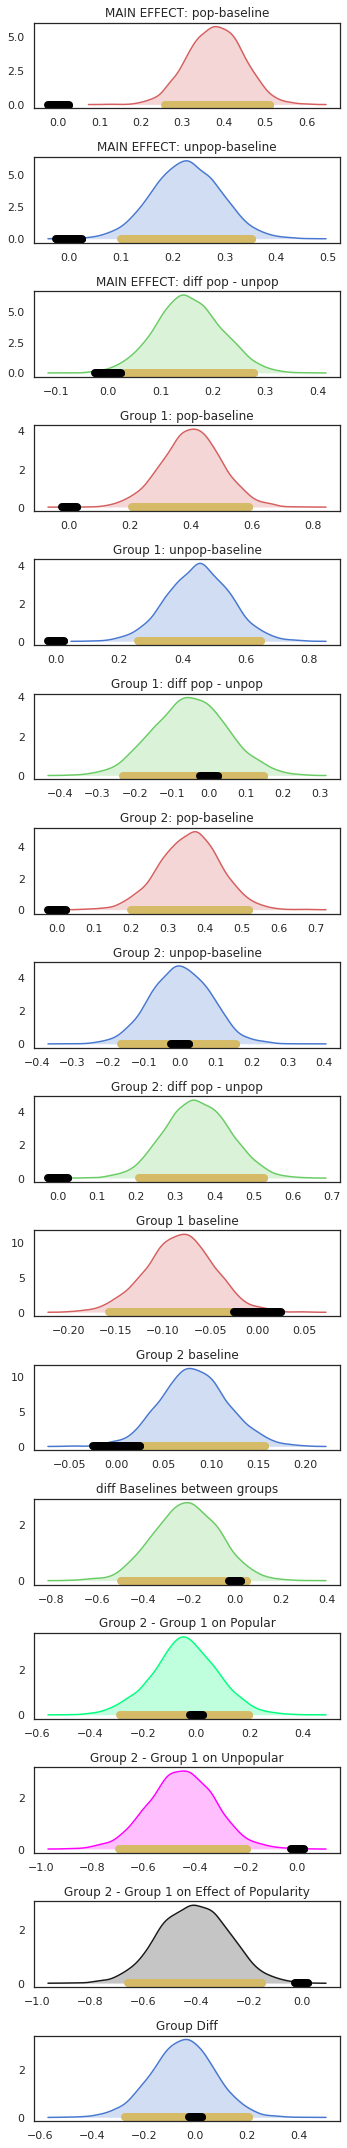

In [14]:
#### import matplotlib.pyplot as plt
import seaborn as sns
from bayesian_bootstrap.bootstrap import mean, highest_density_interval
import pandas as pd
import matplotlib.pyplot as plt
import numpy.ma as ma
import numpy as np

fit_df_2 = fit_3dprime_interaction_full_no_negs.to_dataframe()
a0 = fit_df_2['a0']

NxSubjectLvl=108
NxBetweenLvl=2
NxWithinLvl=3
NxSamples=len(a0)
W=np.zeros((NxSubjectLvl, NxBetweenLvl, NxWithinLvl,NxSamples))
# Initialize the array with zeros
mSxBxW = np.zeros((NxSubjectLvl, NxBetweenLvl, NxWithinLvl, NxSamples))

# Fill the arrray
for k in range(NxSubjectLvl):
    for i in range(NxWithinLvl):
        for j in range(NxBetweenLvl):
            exec('mu = fit_df_2["a0"]+ fit_df_2["aGroup[{}]"] + fit_df_2["aCondition[{}]"] + fit_df_2["aInteraction[{},{}]"] + fit_df_2["aS[{}]"]'.format(j+1,i+1,i+1,j+1,k+1))
            mSxBxW[k,j,i,:] = mu

# Convert to masked array that masks value '0'.
mSxBxW_ma = ma.masked_equal(mSxBxW, 0)
# print(mSxBxW_ma.shape)

# Mean for subject S across levels of W, within the level of B
mS = ma.mean(mSxBxW_ma, axis=(2))
# print('ms shape')
# print(mS.data.shape)

# Mean for treatment combination BxW, across subjects S
mBxW = mSxBxW_ma.mean(axis=(0))
# print('mBxW shape')
# print(mBxW.data.shape)

# Mean for level B, across W and S
# Keeping the dimension of axis 1 in order to have the broadcasting work correctly when calculating bBxW.
mB = ma.mean(mBxW, axis=(1), keepdims=True)
# print('mb shape')
# print(mB.shape)
# Mean for level W, across B and S
# Keeping the dimension of axis 0 in order to have the broadcasting work correctly when calculating bBxW.
mW = ma.mean(mBxW, axis=(0), keepdims=True)
# print('mw shape')
# print(mW.data.shape)

# Equation 20.3
m = ma.mean(mBxW, axis=(0,1))
b0 = m
# print('Mean baseline yield: {}'.format(b0.mean()))
# print(b0.shape)

# Equation 20.4
# Suppress the dimension with size one for mB in order to have the broadcasting work properly.
bB = mB.squeeze() - m

# Equation 20.5
# Suppress the dimension with size one for mW in order to have the broadcasting work properly.
bW = mW.squeeze() - m

# Equation 20.6
bBxW = mBxW - mB - mW + m
# print(bBxW.shape)

# Equation 20.7
bS = mS - mB.squeeze()

#Extract data
# print('MEAN: {}'.format(m))
mbase1 = bW[0,:]
# print('mean bl')
# print(np.mean(mbase1))
mpop1 = bW[1,:]
# print('mean pop')
# print(np.mean(mpop1))

munpop1 = bW[2,:]
# print('mean unpop')
# print(np.mean(munpop1))

mpop_dBase1 = mpop1-mbase1
munpop_dBase1 = munpop1-mbase1
mdiff_pop_unpop1 = mpop1-munpop1

group1=bB[0,:]
group2=bB[1,:]

base1 = bBxW[0,0,:]
pop1 = bBxW[0,1,:]
unpop1 = bBxW[0,2,:]

pop_dBase1 = (pop1+mpop1+group1)-(base1+mbase1+group1)
unpop_dBase1 = (munpop1+unpop1+group1)-(base1+mbase1+group1)
diff_pop_unpop1 = pop_dBase1-unpop_dBase1

base2 = bBxW[1,0,:]
pop2 = bBxW[1,1,:]
unpop2 = bBxW[1,2,:]

pop_dBase2 = (pop2+mpop1+group2)-(base2+mbase1+group2)
unpop_dBase2 = (munpop1+unpop2+group2)-(base2+mbase1+group2)
diff_pop_unpop2 = pop_dBase2-unpop_dBase2
diff_base=(base1+mbase1+group1)-(base2+mbase1+group2)

pop_diff=pop_dBase2-pop_dBase1
unpop_diff=unpop_dBase2-unpop_dBase1
diff_effect=diff_pop_unpop1-diff_pop_unpop2
group_diff=group1-group2
z=0
for i in pop_diff:
    if i>0:
        z+=1
print('percentage of parameters above 0 = {}'.format((z/len(pop_diff))))
print('')


#Compute HDIs
ml_ct, mr_ct = highest_density_interval(mpop_dBase1)
ml_cp, mr_cp = highest_density_interval(munpop_dBase1)
ml_d, mr_d = highest_density_interval(mdiff_pop_unpop1)

l_ct, r_ct = highest_density_interval(pop_dBase1)
l_cp, r_cp = highest_density_interval(unpop_dBase1)
l_d, r_d = highest_density_interval(diff_pop_unpop1)

hl_ct, hr_ct = highest_density_interval(pop_dBase2)
hl_cp, hr_cp = highest_density_interval(unpop_dBase2)
hl_d, hr_d = highest_density_interval(diff_pop_unpop2)
hl_dr, hr_dr = highest_density_interval(diff_base)
lf,bf = highest_density_interval(base1)
la,ba= highest_density_interval(base2)


zhl_ct, zhr_ct = highest_density_interval(pop_diff)
zhl_cp, zhr_cp = highest_density_interval(unpop_diff)
zhl_cr, zhr_cr = highest_density_interval(diff_effect)

zhl_cf, zhr_cf = highest_density_interval(group_diff)

rope=0.025

sns.set(style="white",
        palette="muted",
        color_codes=True)

f, axs = plt.subplots(16, 1, figsize=(5, 30),sharex=False)

ax0=sns.distplot(mpop_dBase1, hist=False,kde_kws={"shade": True},color="r", ax=axs[0])
ax0.set(title='MAIN EFFECT: pop-baseline',xlabel='')

axs[0].plot([ml_ct, mr_ct],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[0].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax1=sns.distplot(munpop_dBase1, hist=False,kde_kws={"shade": True},color="b", ax=axs[1])
ax1.set(title='MAIN EFFECT: unpop-baseline',xlabel='')

axs[1].plot([ml_cp, mr_cp],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[1].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax1=sns.distplot(mdiff_pop_unpop1, hist=False,kde_kws={"shade": True},color="g", ax=axs[2])
ax1.set(title='MAIN EFFECT: diff pop - unpop',xlabel='')

axs[2].plot([ml_d, mr_d],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[2].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')


ax0=sns.distplot(pop_dBase1, hist=False,kde_kws={"shade": True},color="r", ax=axs[3])
ax0.set(title='Group 1: pop-baseline',xlabel='')

axs[3].plot([l_ct, r_ct],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[3].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax1=sns.distplot(unpop_dBase1, hist=False,kde_kws={"shade": True},color="b", ax=axs[4])
ax1.set(title='Group 1: unpop-baseline',xlabel='')

axs[4].plot([l_cp, r_cp],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[4].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax1=sns.distplot(diff_pop_unpop1, hist=False,kde_kws={"shade": True},color="g", ax=axs[5])
ax1.set(title='Group 1: diff pop - unpop',xlabel='')

axs[5].plot([l_d, r_d],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[5].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax0=sns.distplot(pop_dBase2, hist=False,kde_kws={"shade": True},color="r", ax=axs[6])
ax0.set(title='Group 2: pop-baseline',xlabel='')

axs[6].plot([hl_ct, hr_ct],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[6].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax1=sns.distplot(unpop_dBase2, hist=False,kde_kws={"shade": True},color="b", ax=axs[7])
ax1.set(title='Group 2: unpop-baseline',xlabel='')

axs[7].plot([hl_cp, hr_cp],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[7].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax1=sns.distplot(diff_pop_unpop2, hist=False,kde_kws={"shade": True},color="g", ax=axs[8])
ax1.set(title='Group 2: diff pop - unpop',xlabel='')

axs[8].plot([hl_d, hr_d],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[8].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')


ax0=sns.distplot(base1, hist=False,kde_kws={"shade": True},color="r", ax=axs[9])
ax0.set(title='Group 1 baseline',xlabel='')

axs[9].plot([lf, bf],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[9].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax1=sns.distplot(base2, hist=False,kde_kws={"shade": True},color="b", ax=axs[10])
ax1.set(title='Group 2 baseline',xlabel='')

axs[10].plot([la, ba],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[10].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax1=sns.distplot(diff_base, hist=False,kde_kws={"shade": True},color="g", ax=axs[11])
ax1.set(title='diff Baselines between groups',xlabel='')

axs[11].plot([hl_dr, hr_dr],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[11].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')


ax0=sns.distplot(pop_diff, hist=False,kde_kws={"shade": True},color="springgreen", ax=axs[12])
ax0.set(title='Group 2 - Group 1 on Popular',xlabel='')

axs[12].plot([zhl_ct, zhr_ct],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[12].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax0=sns.distplot(unpop_diff, hist=False,kde_kws={"shade": True},color="fuchsia", ax=axs[13])
ax0.set(title='Group 2 - Group 1 on Unpopular',xlabel='')

axs[13].plot([zhl_cp, zhr_cp],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[13].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax0=sns.distplot(diff_effect, hist=False,kde_kws={"shade": True},color="k", ax=axs[14])
ax0.set(title='Group 2 - Group 1 on Effect of Popularity',xlabel='')

axs[14].plot([zhl_cr, zhr_cr],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[14].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')

ax1=sns.distplot(group_diff, hist=False,kde_kws={"shade": True},color="b", ax=axs[15])
ax1.set(title='Group Diff',xlabel='')

axs[15].plot([zhl_cf, zhr_cf],[0,0],linewidth=8.0,label='95% HDI',marker='o',color='y')
axs[15].plot([-rope, rope],[0,0],linewidth=8.0,label='ROPE',marker='o',color='black')




plt.tight_layout()
plt.show()
